In [1]:
import numpy as np
import math
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import torch
from PINN import PINN

In [2]:
%load_ext autoreload
%autoreload 2

# 2D examples 
#### Source: https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a

## 4) A thin square plate with the side of 10 unit length. The temperature everywhere inside the plate is originally 0 degree (at t = 0), let’s see the diagram below (this is not realistic, but it’s good for exercise)

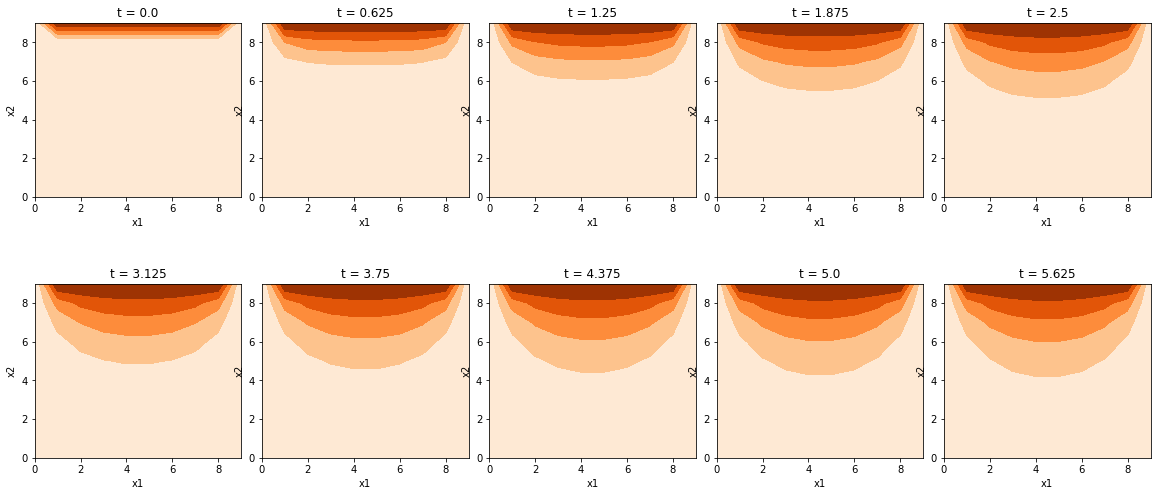

In [3]:
# Initialization
plate_length = 10
max_iter_time = 50
alpha = 2
delta_x = 1
delta_t = (delta_x ** 2)/(4 * alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)


###### COPIED FROM SOURCE - SOLUTION TO THE PLATE PROBLEM ######

# Initialize solution: the grid of u(k, i, j)
u = np.empty((max_iter_time, plate_length, plate_length))
# Initial condition everywhere inside the grid
u_initial = 0
# Boundary conditions
u_top = 100.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0
# Set the initial condition
u.fill(u_initial)
# Set the boundary conditions
u[:, (plate_length-1):, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (plate_length-1):] = u_right


def calculate(u):
    for k in range(0, max_iter_time-1, 1):
        for i in range(1, plate_length-1, delta_x):
            for j in range(1, plate_length-1, delta_x):
                u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]
        #print(f"timestep: {k}")
    return u

# Do the calculation here
u = calculate(u)

###### END OF COPIED CODE ######

# Plotting the proposed solution 
num_images = 10
idx_diff_layers = np.floor(max_iter_time/num_images)
fig, axs = plt.subplots(2,5, figsize=(20, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

for i in range(10):
    time_idx = int(i*idx_diff_layers)
    axs[i].contourf(u[time_idx],5,cmap=plt.cm.Oranges)
    axs[i].set_title(f"t = {time_idx * delta_t}")
    axs[i].set_xlabel("x1")
    axs[i].set_ylabel("x2")


N_boundary: 1000, N_collocation: 1000, N_test: 5000


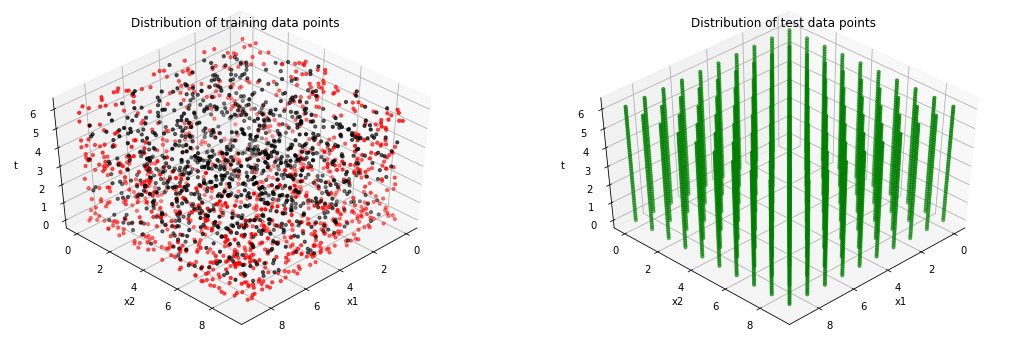

In [4]:
# SEE TRAINING DATA POINTS DISTRIBUTION

# Load datasets and problem data (diffusivity and dimension)
PATH = "./plate_dataset"
checkpoint = torch.load(PATH)
x_train = checkpoint['x_train']
y_train = checkpoint['y_train']
x_test = checkpoint['x_test']
y_test = checkpoint['y_test']
input_size = checkpoint['input_size']
alpha = checkpoint['alpha']
N_test = checkpoint['N_test']
N_boundary = checkpoint['N_boundary']
N_collocation = checkpoint['N_collocation']
t_down_limit = checkpoint['t_down_limit']
t_up_limit = checkpoint['t_up_limit']
x_down_limit = checkpoint['x_down_limit']
x_up_limit = checkpoint['x_up_limit']

# Amount of boundary, collocation and test points
print(f"N_boundary: {N_boundary}, N_collocation: {N_collocation}, N_test: {N_test}")

# Plotting the point distribution in (t, x1, x2) to observe the distribution of the data generated
fig = plt.figure(figsize=(18,6))

# Left plot: boundary points in red, collocation points in black
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_train[N_boundary:,1].detach().numpy(), x_train[N_boundary:,2].detach().numpy(), x_train[N_boundary:,0].detach().numpy(), color = 'black',marker= 'o', s=10)
ax1.scatter(x_train[:N_boundary,1].detach().numpy(), x_train[:N_boundary,2].detach().numpy(), x_train[:N_boundary,0].detach().numpy(), color = 'red',marker= 'o', s=10)
ax1.set_title('Distribution of training data points')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('t');
ax1.view_init(45, 45) # adjust these angles to see differently

# Right plot: you can see a grid of points (the one we used above to compute the source solution)
# We will compare the results obtained with the source solution in the grid to the ones obtained by the NN 
# in those points
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x_test[:,1].detach().numpy(), x_test[:,2].detach().numpy(), x_test[:,0].detach().numpy(), color = 'green', marker= 'o', s=10)
ax2.set_title('Distribution of test data points')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('t');
ax2.view_init(45, 45) # adjust these angles to see differently

# Training points: red are boundary/initial points; black are collocation point
# Test points: the ones used in the grid from the source resolution

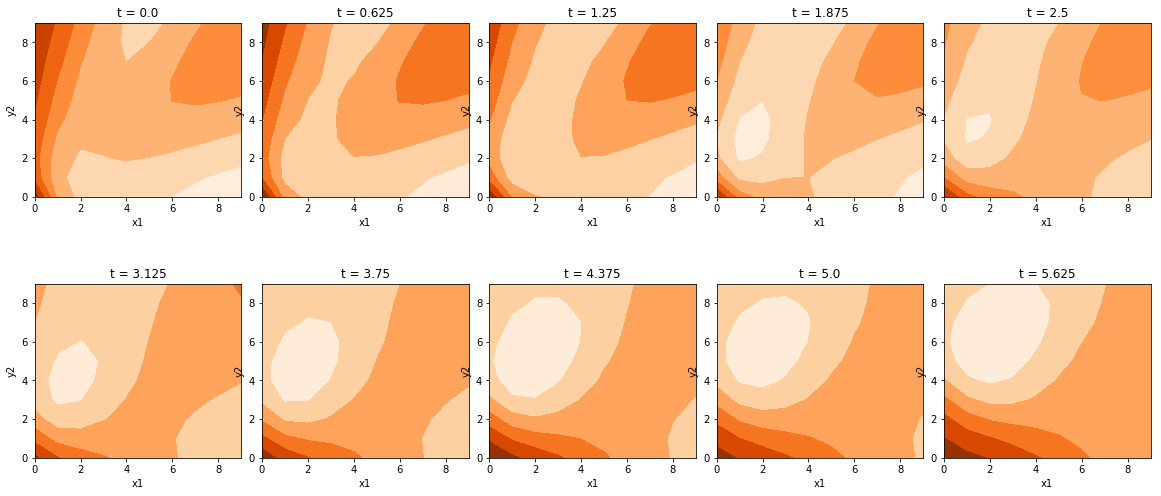

In [5]:
# SEE MODEL PREDICTION

# INITIAL MODEL (NO TRAINING, ONLY INITIALIZED)
# Load model
PATH = "initial_model"
checkpoint = torch.load(PATH)
model_dict = checkpoint['model_dict']
hidden_sizes = checkpoint['hidden_sizes']
output_size = checkpoint['output_size']

model1 = PINN(h_sizes=hidden_sizes, out_size=output_size)
model1.load_state_dict(model_dict)
model1.eval()

# Evaluate model in the grid
u_model1 = np.zeros((max_iter_time, plate_length, plate_length))
x = np.arange(0, plate_length)*delta_x
t = np.arange(0, max_iter_time)*delta_t
for i, t_i in enumerate(t):
    for j, x1_j in enumerate(x):
        for k, x2_k in enumerate(x):
            u_model1[i, j, k] = model1(torch.tensor(np.array([t_i, x1_j, x2_k]).astype(np.float32)))

# Plotting initial model
num_images = 10
idx_diff_layers = np.floor(max_iter_time/num_images)
fig, axs = plt.subplots(2,5, figsize=(20, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

for i in range(10):
    time_idx = int(i*idx_diff_layers)
    axs[i].contourf(u_model1[time_idx],5,cmap=plt.cm.Oranges)
    axs[i].set_title(f"t = {time_idx * delta_t}")
    axs[i].set_xlabel("x1")
    axs[i].set_ylabel("y2")

# TERRIBLE!

Model before training MSE = 1316.7394622113134
Model after training MSE = 133.86128582888904


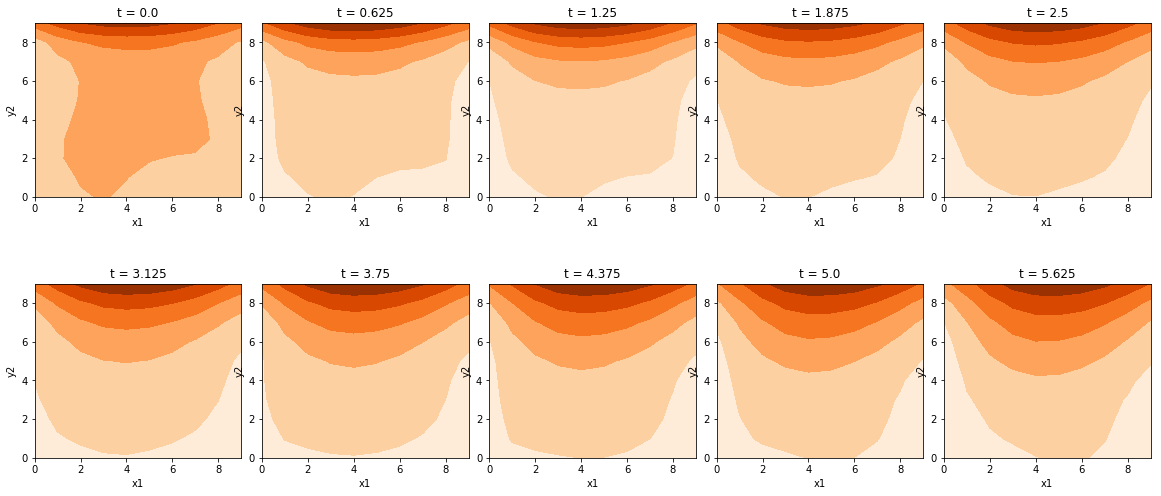

In [6]:
# AFTER TRAINING
# Load model
PATH = "final_model1"
checkpoint = torch.load(PATH)
model_dict = checkpoint['model_dict']
hidden_sizes = checkpoint['hidden_sizes']
output_size = checkpoint['output_size']

model2 = PINN(h_sizes=hidden_sizes, out_size=output_size)
model2.load_state_dict(model_dict)
model2.eval()

# Evaluate model in the grid
u_model2 = np.zeros((max_iter_time, plate_length, plate_length))
x = np.arange(0, plate_length)*delta_x
t = np.arange(0, max_iter_time)*delta_t
for i, t_i in enumerate(t):
    for j, x1_j in enumerate(x):
        for k, x2_k in enumerate(x):
            u_model2[i, j, k] = model2(torch.tensor(np.array([t_i, x1_j, x2_k]).astype(np.float32)))
            
# # Plotting final model
num_images = 10
idx_diff_layers = np.floor(max_iter_time/num_images)
fig, axs = plt.subplots(2,5, figsize=(20, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

for i in range(10):
    time_idx = int(i*idx_diff_layers)
    axs[i].contourf(u_model2[time_idx],5,cmap=plt.cm.Oranges)
    axs[i].set_title(f"t = {time_idx * delta_t}")
    axs[i].set_xlabel("x1")
    axs[i].set_ylabel("y2")
    
# Simple model (only 1 hidden layer, 20 neurons, 100 epochs) does not have a perfect performance
# but already achieves the overall behaviour! 

print(f"Model before training MSE = {np.sum(np.absolute(u_model1 - u)**2)/np.prod(u.shape)}")
print(f"Model after training MSE = {np.sum(np.absolute(u_model2 - u)**2)/np.prod(u.shape)}")